## Modeling chemical systems
**Goal**: explore the thermodynamics of basic chemical systems using RDKit (cheminformatics library for molecular systems) and ASE (simulation library to manipulate and compute molecules and materials).

In this project, we will tackle two of the core aspects related to the application of computers in Chemistry: *cheminformatics* and *simulation*. The first is more related to the management and processing of chemical information, while the latter engulfs multiple kinds of fully *in-silico* approaches to explore chemical systems (e.g. DFT, ab initio calculations, molecular dynamics...).

### RDKit
The [RDKit](https://www.rdkit.org) is one of the most widespread packages for cheminformatics in the Python ecosystem, providing a very powerful toolkit to manipulate, depict and work with molecules. While it is probably not the most friendly library to the average Python user, a basic knowledge on its basics can be really useful, especially to work with molecular databases or fingerprints.

Here, we will just cover a very basic usage pipeline for RDKit: read molecules from string representations (SMILES and SMARTS), showcase the corresponding molecules and reactions in the Jupyter Notebook, and then generate 3D coordinates from these molecular representations to allow further simulation.

### ASE
[ASE](https://wiki.fysik.dtu.dk/ase/) (Atomic Simulation Environment) is, as expected from its name, a Python-based toolkit to manage atom-level simulations of molecules and materials. At its core, the idea behind ASE is to be a simple Python wrapper capable of seamlessly using other codes as *calculators*. In this way, it is possible to leverage efficient and well-established codes for computational chemistry (implementing semi-empirical, DFT or ab initio methods), combined with a Pythonic interface to manage the obtained results.

### XTB
[XTB](https://xtb-docs.readthedocs.io/en/latest/) (eXtended Tight Binding) is a program developed by S. Grimme, which implements, among others, the GFN2-XTB method for electronic structure calculations. This method is a very fast semi-empirical method allowing to obtain reasonable-quality results for geometries, forces and non-covalent interactions with a reduced computational cost.
While of course the accuracy of such a method is not comparable to that of more computationally-demanding DFT or ab initio methods, it provides good approximations for simple systems, and therefore we will employ it as the main ASE calculator throughout this project.

In [1]:
from rdkit import Chem
from rdkit.Chem import PandasTools,AllChem
import rdkit
import ase
import ase.io
from ase.build import molecule
from xtb.ase.calculator import XTB
import pandas as pd
from IPython.core.display import HTML
from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
from io import StringIO
from jupyter_jsmol import JsmolView

PandasTools.RenderImagesInAllDataFrames(images=True)

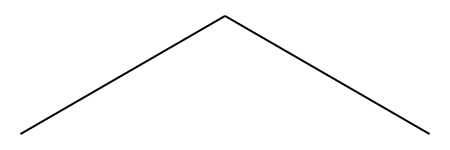

In [2]:
### RDKit basics: read a molecule from its SMILES representation and display it in the notebook
smiles_propane = "CCC"
propane = Chem.MolFromSmiles(smiles_propane)
propane

,0
0,
1,
2,
3,

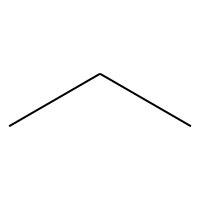
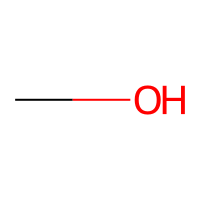
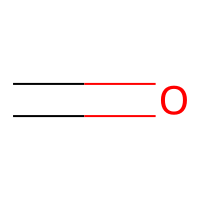
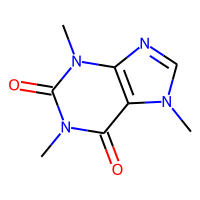

In [3]:
# It is also possible to have multiple molecules, for example inside a DataFrame

smiles = ["CCC","CO","C=O","CN1C=NC2=C1C(=O)N(C(=O)N2C)C"]
molecules = [Chem.MolFromSmiles(smi) for smi in smiles]
df = pd.DataFrame(molecules)
#PandasTools.ChangeMoleculeRendering(df,renderer="PNG")
HTML(df.to_html(escape=False))

These are "conceptual" molecules, with 2D structures (like a paper drawing), but we can embed actual 3D structures in the molecule object, which we can use for simulation.

As there are many possibilities (flexibility, rotatable bonds...) it is interesting to try multiple structures (**conformers**) and choose the best. The approach involves the use of a very simple simulation (*molecular mechanics*), which should work well enough for simple organic molecules, getting an ensemble of *N* conformers.

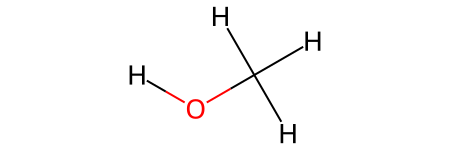

In [4]:
### First, we should add hydrogens, which are omitted from SMILES and from basic RDKit.Molecule objects

methanol = molecules[1]   # methanol
methanol.UpdatePropertyCache()
Chem.SanitizeMol(methanol)
methanol = Chem.AddHs(methanol)

methanol

In [5]:
# Embed multiple 3D structures in the molecule, and then optimize them with MMFF force field to have more reasonable
# geometries and an energy value
Nconf = 50
AllChem.EmbedMultipleConfs(methanol,numConfs=Nconf)
conformer_info = AllChem.MMFFOptimizeMoleculeConfs(methanol)

# And we will have 50 different structures and energies: we want the one with the lowest energy
conformer_energies = [item[1] for item in conformer_info]

# However, for such a simple molecule, most (if not all) the MMFF optimizations will go to the same minimum

In [6]:
# For generality, get the index of the conformer with minimum energy, to then grab its corresponding geometry
best_ndx = int(np.argmin(conformer_energies))
# Retrieve 3D geometry
methanol_xyz = Chem.MolToXYZBlock(methanol,confId=best_ndx)

In [7]:
### JSMol-based interactive visualization. Remember to close it to avoid performance issues!
# Simplest way to manage this is to write to file
with open("methanol_test.xyz","w") as fout:
    fout.write(methanol_xyz)


In [10]:
view = JsmolView.from_file("methanol_test.xyz")

view

JsmolView(layout=Layout(align_self='stretch', height='400px'))

In [ ]:
view.script("background white") 

In [9]:
view.close()

If we instead consider a larger, more flexible molecule, we will encounter more distinct conformers

In [ ]:
mol_larger = Chem.MolFromSmiles("OCCCOC")  
mol_larger.UpdatePropertyCache()
Chem.SanitizeMol(mol_larger)
mol_larger = Chem.AddHs(mol_larger)
mol_larger

In [ ]:
# Embed multiple 3D structures in the molecule, and then optimize them with MMFF force field to have more reasonable
# geometries and an energy value
Nconf = 50
AllChem.EmbedMultipleConfs(mol_larger,numConfs=Nconf)
conformer_info = AllChem.MMFFOptimizeMoleculeConfs(mol_larger)

# And we will have 50 different structures and energies: we want the one with the lowest energy
conformer_energies = [item[1] for item in conformer_info]

fig = plt.figure()
ax = fig.add_subplot()
ax.hist(conformer_energies)
ax.set_xlabel("Energy/kcal mol-1")
ax.set_ylabel("Counts")

# And there is a distribution of energies

In [ ]:
# For generality, get the index of the conformer with minimum energy, to then grab its corresponding geometry
best_ndx = int(np.argmin(conformer_energies))
worst_ndx = int(np.argmax(conformer_energies))
# Retrieve 3D geometry
best_xyz = Chem.MolToXYZBlock(mol_larger,confId=best_ndx)
worst_xyz = Chem.MolToXYZBlock(mol_larger,confId=worst_ndx)

In [ ]:
# Visualizations will show different conformers
with open("larger_conf1.xyz","w") as fout:
    fout.write(best_xyz)
with open("larger_conf2.xyz","w") as fout:
    fout.write(worst_xyz)

In [ ]:
view1 = JsmolView.from_file("larger_conf1.xyz")
view1

In [ ]:
view1.close()

In [ ]:

view2 = JsmolView.from_file("larger_conf2.xyz")
view2

In [ ]:
view2.close()

In [ ]:
# Indeed, now the RDKit representation will showcase the 3D structure
mol_larger

In [ ]:
# It is also possible to define chemical reactions: here, we might use the SMARTS nomenclature
# This can be a bit convoluted, so we will only see a simple example: ester hydrolysis

# CH3-C(=O)-OCH3 + H2O -> CH3-C(=O)-OH + CH3OH. SMILES are:
smiles_hydrolysis = ["CC(=O)OC","O","CC(=O)O","CO"]
mols_hydrolysis = [Chem.AddHs(Chem.MolFromSmiles(smi)) for smi in smiles_hydrolysis]

for mol in mols_hydrolysis:
    display(mol)

# Not too pretty representation: now we will define the reaction

In [ ]:
## Simple irreversible reaction in SMARTS: a.b>>c.d. Molecules must also be converted, so:
smarts_hydrolysis = [Chem.MolToSmarts(mol) for mol in mols_hydrolysis]
print(smarts_hydrolysis)
# Quite ugly, but:

reaction_smarts = "{}.{}>>{}.{}".format(*smarts_hydrolysis)
rxn = Chem.AllChem.ReactionFromSmarts(reaction_smarts)
rxn

In [ ]:
### ASE basics: load a molecule, set up a calculator and compute its energy
# Here, we need 3D geometries: we can use the ones produced by RDKit + conformer embedding 
methanol_ase = ase.io.read("methanol_test.xyz")
methanol_ase
# we do not obtain a representation now, but a simplified depiction of how ASE "sees" the system: Atoms object

In [ ]:
# We have to assign a calculator: we are using the XTB one
methanol_ase.calc = XTB(method="GFN2-xTB")

# Once this is assigned, ASE will call XTB to compute the electronic structure of our molecule
energy = methanol_ase.get_potential_energy()
print("Absolute energy of methanol: {:.2f} eV".format(energy))

In [ ]:
# We may also get other properties: for example, all interatomic distances, atomic numbers...
distance_array = methanol_ase.get_all_distances()
print("Distances:")
print(distance_array)

at_numbers = methanol_ase.get_atomic_numbers()
print("Atomic numbers:")
print(at_numbers)

# Use autocompletion to see the .get... methods of the ASE.Atoms object 

## The project

Our target reaction will be the nucleophilic substitution over alkyl iodides:

$CH_3I + Nu^- \rightarrow CH_3Nu + I^-$

Why have we chosen this system? It's a very well-known reaction, large scope and benchmark for the nucleophilicity of different entering groups: therefore, it is a very good playground to explore basic calculations.

The goals of this project are:
- Define the participating molecules and display them in the notebook, using RDKit.
- Define the corresponding *reactions* with SMARTS and RDKit.
- Extract 3D geometries using conformer embedding.
- Load 3D geometries as ASE.Atoms objects.
- Using the XTB calculator, obtain the relative energy of the reaction (products - reactants).
- Compare XTB energies with higher-quality DFT energies available in the literature.

For the sake of simplicity, we will only be considering the **thermodynamics** of the process. A complete treatment of the $S_N^2$ reaction would require to compute the transition state where the nucleophile enters and the leaving group is released, to tackle the **kinetics**. However, modeling this with SMILES will not be possible, and would require to use external molecular modeling programs.

#### Reference for $S_N^2$ results:
L. Morán-González, M. Besora, F. Maseras, `Seeking the Optimal Descriptor for SN2 Reactions through Statistical Analysis of Density Functional Theory Results`, *J. Org. Chem.*, **2022**, 87(1):363-372 

### Project steps
1. Define a single nucleophilic substitution reaction ($CH_3I + Cl^- \rightarrow CH_3Cl + I^-$) and plot it.
2. Get the relative energy of the reaction with ASE.
3. Organize the code: write functions to wrap up model generation.
4. Automate the code: from a DataFrame containing SMILES and DFT energies, use a loop to define all SN2 reactions and compute their energies.
5. Compare DFT and XTB results with a scatterplot.

In [ ]:
###### Tests (to be cleaned/removed)

In [ ]:
### Initial test
smiles = ["CBr","[F-]"]
molecs = [Chem.MolFromSmiles(smi) for smi in smiles]

In [ ]:
#PandasTools.RenderImagesInAllDataFrames()
df = pd.DataFrame(molecs)
#PandasTools.ChangeMoleculeRendering(df)

HTML(df.to_html(escape=False))

In [ ]:
### For each molecule, embed 3D conformers and get geometry
m1,m2 = molecs
m1 = Chem.AddHs(m1)
# Embed to 3D structure and apply MMFF optimization
AllChem.EmbedMultipleConfs(m1,numConfs=50)
conformer_info = AllChem.UFFOptimizeMoleculeConfs(m1)
conformer_energies = [item[1] for item in conformer_info]
# get minimum energy
best_ndx = int(np.argmin(conformer_energies))
# Retrieve 3D geometry
xyz = Chem.MolToXYZBlock(m1,confId=best_ndx)


In [ ]:
### Now, prepare ASE 
import ase
from ase.build import molecule
from xtb.ase.calculator import XTB
import ase.io
from io import StringIO

In [ ]:
ff = StringIO(xyz)
ase_mol = ase.io.read(ff,format="xyz")
ase_mol.calc = XTB(method="GFN2-xTB")
energy = ase_mol.get_potential_energy()
print(energy)

In [ ]:
#### Express the "pretty reaction" and work from there
r1 = Chem.MolToSmarts(Chem.AddHs(Chem.MolFromSmiles('CBr')))
r2 = Chem.MolToSmarts(Chem.AddHs(Chem.MolFromSmiles('[F-]')))
p1 = Chem.MolToSmarts(Chem.AddHs(Chem.MolFromSmiles('CF')))
p2 = Chem.MolToSmarts(Chem.AddHs(Chem.MolFromSmiles('[Br-]')))
print(r1)
#the notation for reactions include a dot "." between molecules and an arrow ">>"  to indicate the direction
reaction_smarts = r1 + "." + r2 + ">>" + p1 + "." + p2
rxn = Chem.AllChem.ReactionFromSmarts(reaction_smarts)
rxn

In [ ]:
### We can directly get reactants and products from the reaction
reacts = list(rxn.GetReactants())
prods = list(rxn.GetProducts())

In [ ]:
### Prepare a function which automatically handles conformer generation and selection of the best
def prepare_rdkit_mol(mol,Nconf=50):
    mol.UpdatePropertyCache()
    Chem.SanitizeMol(mol)
    mol = Chem.AddHs(mol)
    # Embed to 3D structure and apply MMFF optimization
    AllChem.EmbedMultipleConfs(mol,numConfs=Nconf)
    conformer_info = AllChem.MMFFOptimizeMoleculeConfs(mol)
    conformer_energies = [item[1] for item in conformer_info]
    # get minimum energy
    best_ndx = int(np.argmin(conformer_energies))
    # Retrieve 3D geometry
    xyz = Chem.MolToXYZBlock(mol,confId=best_ndx)
    return xyz

### And another one to build the ASE Atoms object from there
def prepare_ase_mol(xyz,solvent="none"):
    ff = StringIO(xyz)
    ase_mol = ase.io.read(ff,format="xyz")
    ase_mol.calc = XTB(method="GFN2-xTB",solvent=solvent)
    return ase_mol

In [ ]:


r_energies = []
for rx in reacts:
    xyz = prepare_rdkit_mol(rx)
    mol = prepare_ase_mol(xyz)
    r_energies.append(mol.get_potential_energy())
p_energies = []
for px in prods:
    xyz = prepare_rdkit_mol(px)
    mol = prepare_ase_mol(xyz)
    p_energies.append(mol.get_potential_energy())

In [ ]:
sum(p_energies) - sum(r_energies)

In [ ]:
list(prods[0].GetAtoms())

In [ ]:
xyz1 = prepare_rdkit_mol(reacts[0])
with open("ch3br.xyz","w") as fout:
    fout.write(xyz1)

In [ ]:
r_energies

In [ ]:
Chem.AddHs(Chem.MolFromSmiles("[NH2-]"))

In [ ]:
### more automated: consider different substitutions on the basic skeleton
r1 = "CI"
nu_list = ["[F-]","[Cl-]","[Br-]","[OH-]","C[O-]","CC[O-]","O=C[O-]","[NH2-]","N#[C-]"]
p1_list = ["CF","CCl","CBr","CO","CCO","CCCO","C(=O)OC","CN","CC#N"]
p2 = "[I-]"

# Build the reactions by looping through nucleophiles and products

rxn_list = []
for nu,p1 in zip(nu_list,p1_list):
    reacs = [r1,nu]
    prods = [p1,p2]
    
    reacs_mol = [Chem.AddHs(Chem.MolFromSmiles(smi)) for smi in reacs]
    prods_mol = [Chem.AddHs(Chem.MolFromSmiles(smi)) for smi in prods]
    
    smarts_list = [Chem.MolToSmarts(mol) for mol in reacs_mol + prods_mol]
    
    reaction_smarts = "{}.{}>>{}.{}".format(*tuple(smarts_list)) 

    rxn = Chem.AllChem.ReactionFromSmarts(reaction_smarts)
    rxn_list.append(rxn)

In [ ]:
### More compact setup to get energies
def get_energies(mol_list,solvent="none",return_mols=False):
    energies = []
    ase_molecules = []
    for mol in mol_list:
        xyz = prepare_rdkit_mol(mol)
        ase_mol = prepare_ase_mol(xyz,solvent)
        energies.append(ase_mol.get_potential_energy())
        ase_molecules.append(ase_mol)
    if return_mols:
        return energies,ase_molecules
    else:
        return energies

In [ ]:
records = []
for rxn in rxn_list:
    reacts = list(rxn.GetReactants())
    prods = list(rxn.GetProducts())
    e_reacts = get_energies(reacts)
    e_prods = get_energies(prods)
    rel_e = sum(e_prods) - sum(e_reacts)
    print("Reaction with energy %.2f eV" % rel_e)
    display(rxn)

    #records.append((Chem.Draw.ReactionToImage(rxn),rel_e))

In [ ]:
### can we add solvent?

In [ ]:
records = []
for rxn in rxn_list:
    reacts = list(rxn.GetReactants())
    prods = list(rxn.GetProducts())
    e_reacts = get_energies(reacts,"water")
    e_prods = get_energies(prods,"water")
    rel_e = sum(e_prods) - sum(e_reacts)
    print("Reaction with energy %.2f eV" % rel_e)
    display(rxn)

    #records.append((Chem.Draw.ReactionToImage(rxn),rel_e))

In [ ]:
### Read results
info = pd.read_csv("ch3i_b3lyp.csv",index_col=0)

nu_names = list(info.index)
nu_smiles = list(info["Nu_smi"])
prod_smiles = list(info["Prod_smi"])

reac = "CI"
anion = "[I-]"


In [ ]:
### more automated: consider different substitutions on the basic skeleton

# Build the reactions by looping through nucleophiles and products

rxn_dict = {}
for name,nu,prod in zip(nu_names,nu_smiles,prod_smiles):
    reacs = [reac,nu]
    prods = [prod,anion]
    
    try:
        reacs_mol = [Chem.AddHs(Chem.MolFromSmiles(smi)) for smi in reacs]
        prods_mol = [Chem.AddHs(Chem.MolFromSmiles(smi)) for smi in prods]
    except:
        print("Error for %s,%s: skipping" % (nu,prod))
        continue
    
    smarts_list = [Chem.MolToSmarts(mol) for mol in reacs_mol + prods_mol]
    
    reaction_smarts = "{}.{}>>{}.{}".format(*tuple(smarts_list)) 

    rxn = Chem.AllChem.ReactionFromSmarts(reaction_smarts)
    rxn_dict[name] = rxn

In [ ]:
energy_dict = {}
mol_dict = {}
for name,rxn in rxn_dict.items():
    reacts = list(rxn.GetReactants())
    prods = list(rxn.GetProducts())
    e_reacts,rlist = get_energies(reacts,"water",True)
    e_prods,plist = get_energies(prods,"water",True)
    rel_e = sum(e_prods) - sum(e_reacts)
    print("Reaction with energy %.2f eV" % rel_e)
    display(rxn)

    energy_dict[name] = rel_e
    mol_dict[name] = rlist + plist
    #records.append((Chem.Draw.ReactionToImage(rxn),rel_e))

In [ ]:
# add the column
info.loc[:,"xtb"] = info.index.map(energy_dict)
info2 = info.drop("CN")


In [ ]:
info2.loc[:,"err"] = (info2["xtb"] - info2["DG_eV"])/info2["DG_eV"]

In [ ]:
info2.plot.scatter("xtb","DG_eV",c="err",cmap="viridis")

In [ ]:
from jupyter_jsmol import JsmolView

In [ ]:
x = mol_dict["Ts"][2]
view = JsmolView.from_ase(x)

#display(view)
view.script("background white")

In [ ]:
view

In [ ]:
view.close()

In [ ]:
### Optimization?
from ase.optimize import BFGS

# GFN2-XTB-based optimization for the large molecule
ase_larger = prepare_ase_mol(best_xyz)
opti = BFGS(ase_larger)
opti.run()


In [ ]:
ase_larger.write("larger_opti.xyz")